In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
import sklearn
import warnings
from scipy.special import expit, logit
import sksurv.datasets
import numpy as np
import joblib
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import DMatrix
from xgboost import train
from lifelines import CoxPHFitter
from itertools import product
from tqdm import tqdm
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_to_structured
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ParameterGrid
from sksurv.datasets import load_breast_cancer
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv


from sksurv.ensemble import GradientBoostingSurvivalAnalysis


warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
set_config(display="text")

In [2]:
# df_corse=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/dataset_modele_decompte.csv', sep=';')
df=pd.read_csv('output/13_Dataset_modele_full.csv', sep=';')
pd.set_option('display.max_columns', None)



C:\Users\m_bar\AppData\Local\Temp\ipykernel_156560\3845688505.py:2: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('output/13_Dataset_modele_full.csv', sep=';')


In [3]:
df['Feu prévu'] = df['Feu prévu'].astype(bool)
# df_variables = df_corse[[
#     'moyenne precipitations mois', 'moyenne temperature mois',
#     'moyenne evapotranspiration mois', 'moyenne vitesse vent année',
#     'moyenne vitesse vent mois', 'moyenne temperature année',
#     'RR', 'UM', 'ETPMON', 'TN', 'TX', 'évènement', 'décompte', 'Nombre de feu par an',
#     'Nombre de feu par mois', 'jours_sans_pluie', 'jours_TX_sup_30', 
#     'compteur jours vers prochain feu', 'compteur feu carré', 'compteur feu log', 'ETPGRILLE_7j',
#     'moyenne precipitations année', 'moyenne evapotranspiration année'
# ]]

# df_variables.rename(columns={
#     'RR': 'Précipitations en mm',
#     'TN': 'Température minimale sous abri',
#     'TX': 'Température maximale sous abri',
#     'UM': 'Humidité moyenne en %',
#     'ETPMON': 'Evapotranspiration en mm',
       
# }, inplace=True)


In [4]:
# traitement des colonnes avec trop de données manquantes
# threshold = 0.5
# cols_to_keep = df_corse.columns[df_corse.isnull().mean() < threshold]
df_clean = df.copy()

features = [
    'moyenne precipitations mois', 'moyenne temperature mois',
    'moyenne evapotranspiration mois', 'moyenne vitesse vent année',
    'moyenne vitesse vent mois', 'moyenne temperature année',
    'RR', 'UM', 'ETPMON', 'TN', 'TX', 'Nombre de feu par an',
    'Nombre de feu par mois', 'jours_sans_pluie', 'jours_TX_sup_30', 
     'ETPGRILLE_7j',
    'compteur jours vers prochain feu','compteur feu log','Année', 'Mois',
    'moyenne precipitations année', 'moyenne evapotranspiration année'
]
features = [f for f in features if f in df_clean.columns]


df_clean["décompte"] = df_clean["décompte"].fillna(0)


#### XGBoost Regressor Survival Cox

#### GridSearch et XGBoost

In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from xgboost import XGBRegressor, DMatrix, train
# from sksurv.util import Surv
# from lifelines import CoxPHFitter

# # 🔹 Préparation des données réelles
# df_clean = df_clean.rename(columns={"Feu prévu": "event", "décompte": "duration"})
# y_structured = Surv.from_dataframe("event", "duration", df_clean)

# X = df_clean[features]
# y = y_structured

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# event_train = y_train["event"]
# duration_train = y_train["duration"]
# event_test = y_test["event"]
# duration_test = y_test["duration"]

# # 🔹 Pipeline XGBoost survie
# pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("xgb", XGBRegressor(
#         objective="survival:cox",
#         n_estimators=100,
#         learning_rate=0.1,
#         max_depth=5,
#         tree_method="hist",
#         device="cuda",
#         random_state=42
#     ))
# ])
# pipeline.fit(X_train, duration_train, xgb__sample_weight=event_train)

# # 🔹 Prédictions réelles (log(HR))
# log_hr_test = pipeline.predict(X_test)

# # 🔹 Jeu factice pour estimer H0(t)
# df_fake = pd.DataFrame({
#     "duration": duration_train,
#     "event": event_train,
#     "const": 1
# })

# dtrain_fake = DMatrix(df_fake[["const"]])
# dtrain_fake.set_float_info("label", df_fake["duration"])
# dtrain_fake.set_float_info("label_lower_bound", df_fake["duration"])
# dtrain_fake.set_float_info("label_upper_bound", df_fake["duration"])
# dtrain_fake.set_float_info("weight", df_fake["event"])

# params = {
#     "objective": "survival:cox",
#     "eval_metric": "cox-nloglik",
#     "learning_rate": 0.1,
#     "max_depth": 1,
#     "verbosity": 0
# }
# bst_fake = train(params, dtrain_fake, num_boost_round=100)

# # 🔹 Estimation de H0(t) avec CoxPHFitter
# log_hr_fake = bst_fake.predict(dtrain_fake)  # valeurs constantes
# df_risque = pd.DataFrame({
#     "duration": duration_train,
#     "event": event_train,
#     "log_risque": log_hr_fake
# })
# cph = CoxPHFitter()
# # log_risque contient quasiment la même valeur pour tous les individus (normal, car le modèle XGBoost a été entraîné sur un dataset factice avec une seule constante).
# # Du coup, lifelines n’arrive pas à ajuster les coefficients, car il n’y a aucune information discriminante dans log_risque
# df_risque["log_risque"] += np.random.normal(0, 1e-4, size=len(df_risque))

# jours = [30, 60, 90, 180]

# # Extraire la fonction H0(t)
# h0 = cph.baseline_cumulative_hazard_

# # Interpolation de H0(t) pour les jours souhaités
# h0_interp = h0.reindex(jours, method='nearest')  # ou interpolation linéaire si besoin
# H0_t = h0_interp.values.flatten()  # shape (n_jours,)

# # Reprend les prédictions de risque du vrai modèle
# df_preds = pd.DataFrame({"log_risque": log_hr_test})
# log_HR = df_preds["log_risque"].values  # shape (n_individus,)

# # Calcul de S(t|x) pour chaque temps t
# S_t = np.exp(-np.outer(H0_t, np.exp(log_HR)))  # shape (n_jours, n_individus)

# # Probabilité d'un feu à l'échéance t
# probas_feu = 1 - S_t.T  # shape (n_individus, n_jours)

# # Mettre en DataFrame avec colonnes explicites
# probas_feu_df = pd.DataFrame(
#     probas_feu,
#     columns=[f"proba_{j}j" for j in jours]
# )



# print(df_risque.isna().sum())

# cph.fit(df_risque, duration_col="duration", event_col="event", show_progress=False)

# # 🔹 Calcul des fonctions de survie individuelles
# df_preds = pd.DataFrame({"log_risque": log_hr_test})
# surv_funcs = cph.predict_survival_function(df_preds)

# # 🔹 Affichage des fonctions de survie (ex : 5 premiers individus)
# plt.figure(figsize=(10, 6))
# for i in range(5):
#     surv_funcs.iloc[:, i].plot(label=f"Individu {i}")
# plt.title("Fonction de survie individuelle (probabilité de ne pas avoir de feu)")
# plt.xlabel("Temps")
# plt.ylabel("S(t) = P(pas de feu à t)")
# plt.legend()
# plt.grid(True)
# plt.show()

# # 🔹 Optionnel : calcul de la probabilité de feu
# # Par exemple à t = 10 :
# t_index = surv_funcs.index.get_indexer([10], method='nearest')[0]
# proba_feu_t10 = 1 - surv_funcs.iloc[t_index]
# print("\nProbabilité de feu à t ≈ 10 pour chaque individu :")
# print(proba_feu_t10.head())


In [6]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from xgboost import XGBRegressor, DMatrix, train
# from sksurv.util import Surv
# from lifelines import CoxPHFitter

# # 🔹 Préparation des données réelles
# df_clean = df_clean.rename(columns={"Feu prévu": "event", "décompte": "duration"})
# y_structured = Surv.from_dataframe("event", "duration", df_clean)

# X = df_clean[features]
# y = y_structured

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# event_train = y_train["event"]
# duration_train = y_train["duration"]
# event_test = y_test["event"]
# duration_test = y_test["duration"]

# # 🔹 Pipeline XGBoost survie
# pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("xgb", XGBRegressor(
#         objective="survival:cox",
#         n_estimators=100,
#         learning_rate=0.1,
#         max_depth=5,
#         tree_method="hist",
#         device="cuda",
#         random_state=42
#     ))
# ])
# pipeline.fit(X_train, duration_train, xgb__sample_weight=event_train)

# # 🔹 Prédictions réelles (log(HR))
# log_hr_test = pipeline.predict(X_test)

# # 🔹 Jeu factice pour estimer H0(t)
# df_fake = pd.DataFrame({
#     "duration": duration_train,
#     "event": event_train,
#     "const": 1
# })

# dtrain_fake = DMatrix(df_fake[["const"]])
# dtrain_fake.set_float_info("label", df_fake["duration"])
# dtrain_fake.set_float_info("label_lower_bound", df_fake["duration"])
# dtrain_fake.set_float_info("label_upper_bound", df_fake["duration"])
# dtrain_fake.set_float_info("weight", df_fake["event"])

# params = {
#     "objective": "survival:cox",
#     "eval_metric": "cox-nloglik",
#     "learning_rate": 0.1,
#     "max_depth": 1,
#     "verbosity": 0
# }
# bst_fake = train(params, dtrain_fake, num_boost_round=100)

# # 🔹 Estimation de H0(t) avec CoxPHFitter
# log_hr_fake = bst_fake.predict(dtrain_fake)
# df_risque = pd.DataFrame({
#     "duration": duration_train,
#     "event": event_train,
#     "log_risque": log_hr_fake
# })
# df_risque["log_risque"] += np.random.normal(0, 1e-4, size=len(df_risque))

# # Ajustement du modèle Cox sur les données factices
# cph = CoxPHFitter()
# cph.fit(df_risque, duration_col="duration", event_col="event", show_progress=False)

# # 🔹 Estimation de H0(t) aux temps donnés
# jours = [30, 60, 90, 180]
# h0 = cph.baseline_cumulative_hazard_
# h0_interp = h0.reindex(jours, method='nearest')
# H0_t = h0_interp.values.flatten()

# # 🔹 Calcul des probabilités de feu
# log_HR = log_hr_test
# S_t = np.exp(-np.outer(H0_t, np.exp(log_HR)))
# probas_feu = 1 - S_t.T

# probas_feu_df = pd.DataFrame(
#     probas_feu,
#     columns=[f"proba_{j}j" for j in jours]
# )
# # # y_test est déjà une structure Surv
# # c_index, concordant, discordant, tied_risk, tied_time = concordance_index_censored(
# #     y_test["event"], y_test["duration"], -log_hr_test  # ⚠️ attention au signe : -log(HR)
# # )

# # print(f"\n🔎 Concordance Index (C-index) sur test : {c_index:.3f}")

# # # 🔹 Affichage des fonctions de survie
# # surv_funcs = cph.predict_survival_function(pd.DataFrame({"log_risque": log_HR}))
# # plt.figure(figsize=(10, 6))
# # for i in range(5):
# #     surv_funcs.iloc[:, i].plot(label=f"Individu {i}")
# # plt.title("Fonction de survie individuelle (probabilité de ne pas avoir de feu)")
# # plt.xlabel("Temps")
# # plt.ylabel("S(t) = P(pas de feu à t)")
# # plt.legend()
# # plt.grid(True)
# # plt.show()

# # # 🔹 Exemple : probabilité de feu à t ≈ 10 jours
# # t_index = surv_funcs.index.get_indexer([10], method='nearest')[0]
# # proba_feu_t10 = 1 - surv_funcs.iloc[t_index]
# # print("\nProbabilité de feu à t ≈ 10 pour chaque individu :")
# # print(proba_feu_t10.head())


### XGBOOST predict_cumulative_hazard_function

In [7]:


# 🔹 Préparation des données réelles
df_clean = df_clean.rename(columns={"Feu prévu": "event", "décompte": "duration"})
y_structured = Surv.from_dataframe("event", "duration", df_clean)

X = df_clean[features]
y = y_structured

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

event_train = y_train["event"]
duration_train = y_train["duration"]
event_test = y_test["event"]
duration_test = y_test["duration"]

# 🔹 Pipeline XGBoost survie avec StandardScaler
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        objective="survival:cox",
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        tree_method="hist",
        device="cuda",
        random_state=42
    ))
])
pipeline.fit(X_train, duration_train, xgb__sample_weight=event_train)

# 🔹 Prédictions réelles (log(HR)) sur données test
log_hr_test = pipeline.predict(X_test)

# 🔹 Jeu factice pour estimer le modèle de Cox
df_fake = pd.DataFrame({
    "duration": duration_train,
    "event": event_train,
    "const": 1
})
dtrain_fake = DMatrix(df_fake[["const"]])
dtrain_fake.set_float_info("label", df_fake["duration"])
dtrain_fake.set_float_info("label_lower_bound", df_fake["duration"])
dtrain_fake.set_float_info("label_upper_bound", df_fake["duration"])
dtrain_fake.set_float_info("weight", df_fake["event"])

params = {
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "learning_rate": 0.1,
    "max_depth": 1,
    "verbosity": 0
}
bst_fake = train(params, dtrain_fake, num_boost_round=100)

log_hr_fake = bst_fake.predict(dtrain_fake)
df_risque = pd.DataFrame({
    "duration": duration_train,
    "event": event_train,
    "log_risque": log_hr_fake
})
# insertion de bruit pour aider le modèle à converger
df_risque["log_risque"] += np.random.normal(0, 1e-4, size=len(df_risque))

# 🔹 Modèle de Cox factice
cph = CoxPHFitter()
cph.fit(df_risque, duration_col="duration", event_col="event", show_progress=False)

# 🔹 Évaluation avec le c-index
c_index = concordance_index_censored(event_test, duration_test, log_hr_test)[0]
print(f"\nC-index (test) : {c_index:.3f}")


c:\Users\m_bar\Incendie\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\m_bar\Incendie\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\m_bar\Incendie\.venv\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['log_risque'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), Convergen


C-index (test) : 0.579


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# 🔹 Récupération des données
coords_test = df_clean.loc[X_test.index, ["latitude", "longitude", "ville"]].reset_index(drop=True)
df_preds = pd.DataFrame({"log_risque": log_hr_test})
times = [7, 30, 60, 90, 180]
surv_funcs = cph.predict_survival_function(df_preds, times=times)
probas_feu = 1 - surv_funcs.T
probas_feu.columns = [f"proba_{t}j" for t in times]

df_map = pd.concat([coords_test, probas_feu.reset_index(drop=True)], axis=1)

# 🔹 Définition des niveaux de risque
def qualifier_risque(p):
    if p < 0.10:
        return "Très faible", "blue", "[0–10 %]"
    elif p < 0.30:
        return "Faible", "green", "[10–30 %]"
    elif p < 0.60:
        return "Modéré", "yellow", "[30–60 %]"
    elif p < 0.85:
        return "Élevé", "orange", "[60–85 %]"
    else:
        return "Très élevé", "red", "[85–100 %]"

# 🔹 Création de la figure
fig = go.Figure()

for t in times:
    visible = True if t == 7 else False
    niveaux, couleurs, intervalles = zip(*[qualifier_risque(p) for p in df_map[f"proba_{t}j"]])
    
    fig.add_trace(go.Scattermap(
        lat=df_map["latitude"],
        lon=df_map["longitude"],
        mode='markers',
        marker=go.scattermap.Marker(
            size=10,
            color=list(couleurs),
        ),
        text=[
            f"{ville}<br><b>Risque {niveau}</b> {intervalle}<br>({p:.1%})"
            for ville, niveau, intervalle, p in zip(df_map["ville"], niveaux, intervalles, df_map[f"proba_{t}j"])
        ],
        name=f"{t} jours",
        hoverinfo="text",
        visible=visible,
        showlegend=False
    ))

# 🔹 Traces "légende"
legende_risques = [
    ("Très faible", "blue", "[0–10 %]"),
    ("Faible", "green", "[10–30 %]"),
    ("Modéré", "yellow", "[30–60 %]"),
    ("Élevé", "orange", "[60–85 %]"),
    ("Très élevé", "red", "[85–100 %]")
]

for nom, couleur, intervalle in legende_risques:
    fig.add_trace(go.Scattermap(
        lat=[], lon=[],
        mode="markers",
        marker=go.scattermap.Marker(size=10, color=couleur),
        name=f"{nom} {intervalle}",
        showlegend=True,
        hoverinfo="skip",
        visible=True
    ))

# 🔹 Menu déroulant
fig.update_layout(
    updatemenus=[{
        "buttons": [
            {
                "label": f"{t} jours",
                "method": "update",
                "args": [
                    {"visible": [i == j for i in range(len(times))] + [True]*5},
                    {"title": f"Carte des risques d'incendie à {t} jours"}
                ]
            }
            for j, t in enumerate(times)
        ],
        "direction": "down",
        "x": 0.01,
        "xanchor": "left",
        "y": 1.05,
        "yanchor": "top",
        "showactive": True
    }]
)

# 🔹 Paramètres visuels
fig.update_layout(
    map_style="open-street-map",
    map_zoom=6,
    map_center={"lat": df_map["latitude"].mean(), "lon": df_map["longitude"].mean()},
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    title="Carte des risques d'incendie à 7 jours",
    legend_title="Niveau de risque (probabilité)",
    legend=dict(
        title="Niveau de risque (probabilité)",
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="black",
        borderwidth=1,
        x=0.99,  # position horizontale (proche du bord droit)
        xanchor="right",
        y=0.5,   # centré verticalement
        yanchor="middle"
))


fig.show()

In [9]:
print(df_preds)

       log_risque
0        0.552162
1        2.771806
2        0.802865
3        3.294704
4        0.237556
...           ...
29744    0.507413
29745    1.238915
29746    1.107267
29747    7.546012
29748    3.571024

[29749 rows x 1 columns]


In [10]:
print(surv_funcs)

       0      1      2      3      4      5      6      7         8      \
7.0      0.0    1.0    0.0    1.0    0.0    0.0    1.0    0.0  0.935412   
30.0     0.0    1.0    0.0    1.0    0.0    0.0    1.0    0.0  0.920737   
60.0     0.0    1.0    0.0    1.0    0.0    0.0    1.0    0.0  0.905345   
90.0     0.0    1.0    0.0    1.0    0.0    0.0    1.0    0.0  0.891700   
180.0    0.0    1.0    0.0    1.0    0.0    0.0    1.0    0.0  0.851989   

       9      10     11     12     13     14     15     16     17     18     \
7.0      0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0   
30.0     0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0   
60.0     0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0   
90.0     0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0   
180.0    0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0   

       19     20     21     22     23        24     25        26     27   

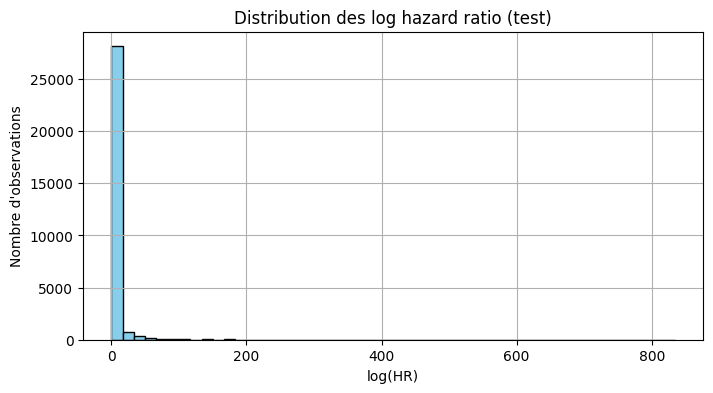

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(log_hr_test, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution des log hazard ratio (test)")
plt.xlabel("log(HR)")
plt.ylabel("Nombre d'observations")
plt.grid(True)
plt.show()

🔥 Très haute proba de feu (>99%) : 14906
💧 Très faible proba de feu (<1%) : 12552


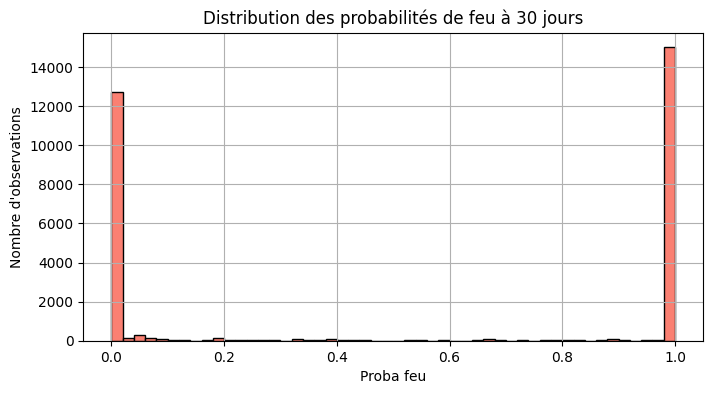

In [12]:
# Seulement la proba à 30 jours par exemple
proba_30j = probas_feu["proba_30j"]

# Cas avec proba > 0.99
print("🔥 Très haute proba de feu (>99%) :", (proba_30j > 0.99).sum())

# Cas avec proba < 1%
print("💧 Très faible proba de feu (<1%) :", (proba_30j < 0.01).sum())

# Histogramme global
plt.figure(figsize=(8, 4))
plt.hist(proba_30j, bins=50, color="salmon", edgecolor="black")
plt.title("Distribution des probabilités de feu à 30 jours")
plt.xlabel("Proba feu")
plt.ylabel("Nombre d'observations")
plt.grid(True)
plt.show()

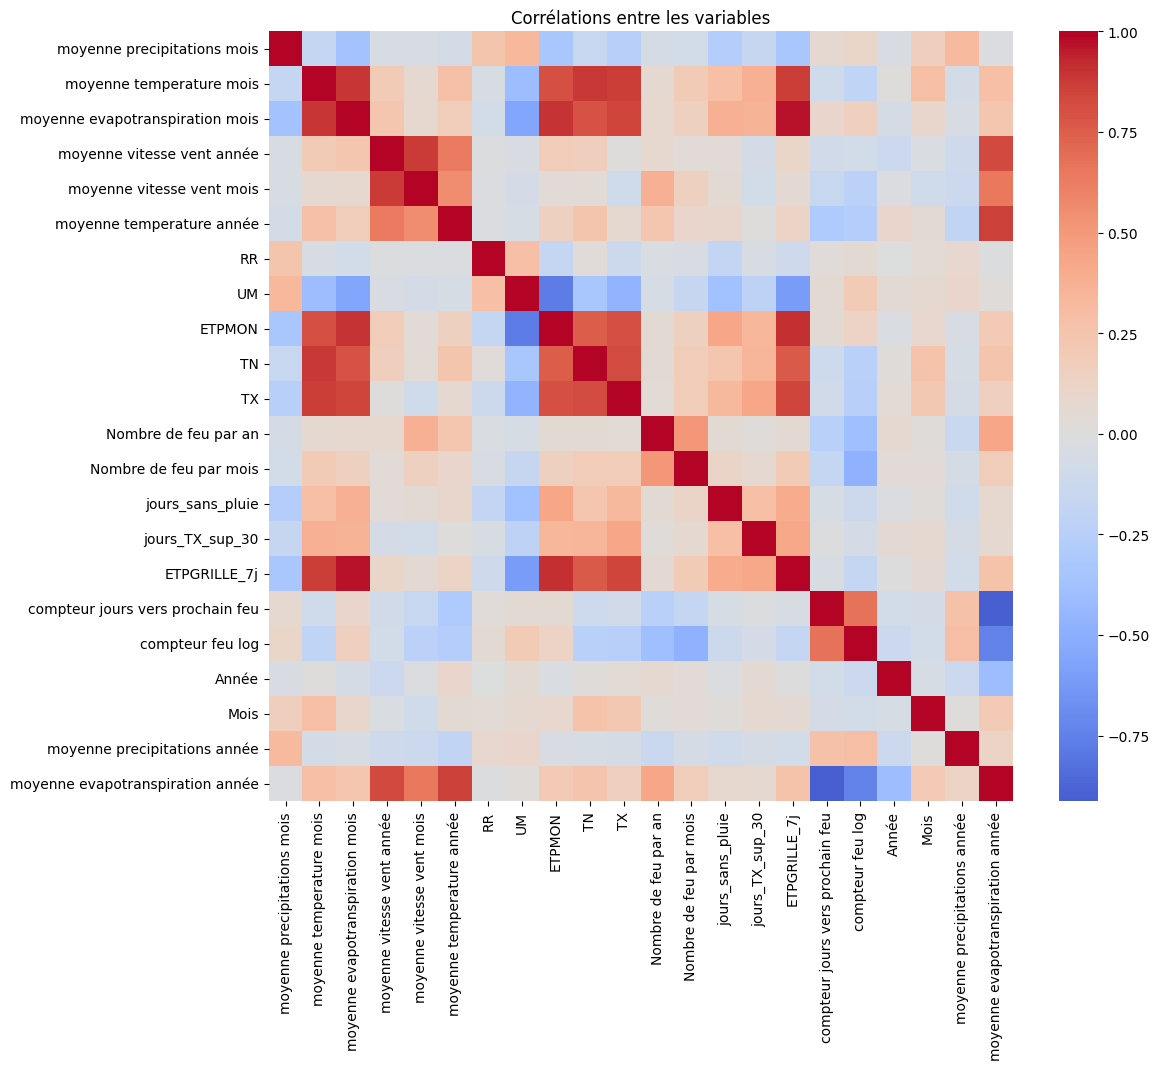

In [13]:
corr = X_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Corrélations entre les variables")
plt.show()


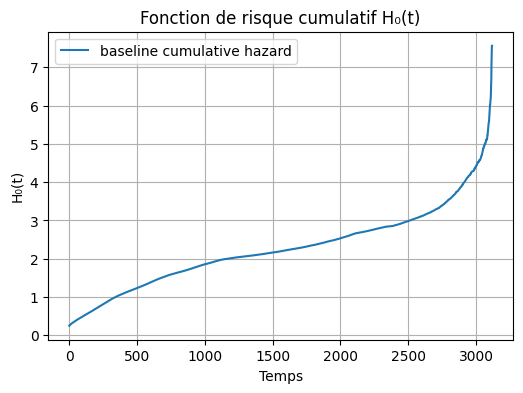

In [14]:
cph.baseline_cumulative_hazard_.plot(title="Fonction de risque cumulatif H₀(t)", figsize=(6,4))
plt.xlabel("Temps")
plt.ylabel("H₀(t)")
plt.grid(True)
plt.show()


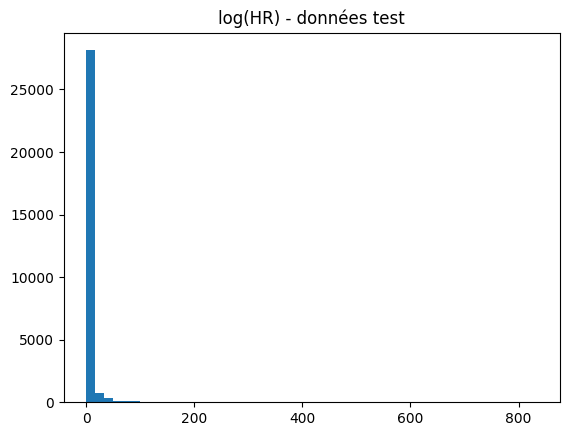

In [15]:
plt.hist(log_hr_test, bins=50)
plt.title("log(HR) - données test")
plt.show()

In [16]:
df_proba = pd.DataFrame(probas_feu)
df_proba.head(100)



,proba_7j,proba_30j,proba_60j,proba_90j,proba_180j
0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
95,1.0,1.0,1.0,1.0,1.0
96,1.0,1.0,1.0,1.0,1.0
97,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0
